Project: Tags an anime image using multiclassifier algorithm using Safebooru datasets.

Summary: Download anime image and its tag from Safebooru. Extract the tags into classes and implement multi label classification algorithm. Train the model and test anime images randomly.

Implementation: Download xml file using Safebooru api, compile file_url into links text file.
Map file name of the link to its tag into safebooru.csv. Train the model and deploy into production.



---

API information: https://safebooru.org/index.php?page=help&topic=dapi



In [0]:
pip install "torch==1.4" "torchvision==0.5.0" #Fastai latest library does not work with pyTorch 1.5

In [0]:
import csv 
import requests 
import xml.etree.ElementTree as ET 
import re
from fastai import *
from fastai.imports import *
from fastai.vision import *

In [0]:
!cp booruimg.tar.gz "/content/gdrive/My Drive/fastai-v3/data/safebooru"

# Getting the Data from Safebooru

In [0]:
#Get xml file from 1 to 9 and save it as feed1.xml, feed2.xml...

for i in range(1,10):
  URL = "https://safebooru.org/index.php?page=dapi&s=post&q=index&pid=" + str(i)
  response = requests.get(URL)
  xml = "feed" + str(i) + ".xml"
  with open(xml, 'wb') as file:
      file.write(response.content)

In [0]:
posts = []
headerAlreadywrite = False
def parseXMLtoLink(xmlfile): 
    
    tree = ET.parse(xmlfile) 
  
    root = tree.getroot() 

    with open('links.csv', 'a') as file:
        for child in root.findall('post'):
            link = child.get('file_url')
            file.write(link + "\n")

def parseXMLtoFileName(xmlfile):
    tree = ET.parse(xmlfile) 
  
    root = tree.getroot() 
    with open('fname.csv', 'a') as file:
      for child in root.findall('post'):
          post = {}
          filename = re.search("(?=\w+\.\w{3,4}$).[a-z|0-9]+", str(child.get('file_url')))
          file.write(filename.group(0) + "\n") 


def parseXMLtoMap(xmlfile):
    
    tree = ET.parse(xmlfile) 
  
    root = tree.getroot() 
    for child in root.findall('post'):
        post = {}
        filename = re.search("(?=\w+\.\w{3,4}$).+", str(child.get('file_url')))
        post['link'] = filename.group(0)
        post['tag'] = child.get('tags')
        posts.append(post)



def savetoCSV(newsitems, filename): 
    global headerAlreadywrite

    fields = ['link', 'tag'] 

    with open(filename, 'a') as csvfile: 
  
        writer = csv.DictWriter(csvfile, fieldnames = fields) 
  
        if (not headerAlreadywrite):
          writer.writeheader() 
          headerAlreadywrite = True
  
        writer.writerows(newsitems) 

Custom download_image function to replace fastai function. The only difference is retaining source file name

Example:
download_images(base_path/file_urls, dest, names=base_path/file_names, max_pics=100)

In [0]:
def download_image(url,dest, timeout=4):
    try: r = download_url(url, dest, overwrite=True, show_progress=False, timeout=timeout)
    except Exception as e: print(f"Error {url} {e}")

def _download_image_inner(dest, info, i, timeout=4):
    url = info[0]
    name = info[1]
    suffix = re.findall(r'\.\w+?(?=(?:\?|$))', url)
    suffix = suffix[0] if len(suffix)>0  else '.jpg'
    download_image(url, dest/f"{name}{suffix}", timeout=timeout)

def download_images(urls:Collection[str], dest:PathOrStr, names:PathOrStr=None, max_pics:int=1000, max_workers:int=8, timeout=4):
    "Download images listed in text file `urls` to path `dest`, at most `max_pics`"
    urls = open(urls).read().strip().split("\n")[:max_pics]
    if names:
      names = open(names).read().strip().split("\n")[:max_pics]
    else:
      names = [f"{index:08d}" for index in range(0,len(urls))]
    info_list = list(zip(urls, names))
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(_download_image_inner, dest, timeout=timeout), info_list, max_workers=max_workers)

In [0]:
#Create link file containing link to download image

for i in range(1,10):
  parseXMLtoLink("feed" + str(i) + ".xml")

In [0]:
#Run all of this many time for each xml file. For example, for feed1.xml, I click parseXMLtoMap, parseXMLtoFileName, savetoCSV once, then change it to feed2.xml and repeat click

In [0]:
parseXMLtoMap("feed1.xml")

In [0]:
parseXMLtoFileName("feed1.xml")

In [0]:
savetoCSV(posts, "safeb.csv") 

In [0]:
#Define path and create booruimg dir to download img
path = Path("")
dest = Path('booruimg')
dest.mkdir(parents=True, exist_ok=True)
path

In [0]:
#Download data
file = "links.csv"
fname = "fname.csv"
download_images(path/file, dest, names=path/fname, max_pics=902)

# Multiclassification training

In [17]:
df = pd.read_csv(path/'safeb.csv')
df.head()

,link,tag
0,0d84ca6d0285831043a8f669affa2c6fff77c697.jpg,1girl akame_ga_kill! bangs black_legwear boot...
1,5403d421584fd78eb86a0542c294e1a9b0114349.jpg,1girl bangs blunt_bangs bow cowboy_shot cure_...
2,5aaa9a45857c1106b447cbf304d033d4d5b5810e.jpg,1girl bangs black_legwear closed_mouth collar...
3,f69aa2084b0d853a30d5874d576dff804a1455cb.jpg,1girl :d bangs black_skirt black_sleeves blue...
4,3015448ffb23be4ebea1ad3e61a867d5efef49fb.jpg,1girl :d absurdly_long_hair bangs black_footw...


In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'safeb.csv', folder=dest) #suffix?
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(data, arch, metrics=acc_02)

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


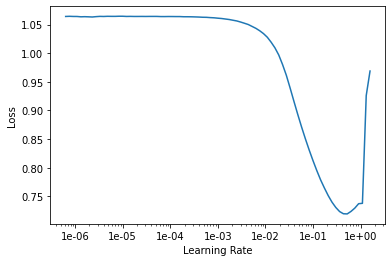

In [48]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [50]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.702499,0.068824,0.975265,06:32
1,0.198262,0.027739,0.991648,06:34
2,0.079306,0.023734,0.992339,06:32
3,0.042102,0.021303,0.992877,06:32
4,0.029227,0.020831,0.992961,06:34


In [0]:
learn.save('/content/stage-1-rn50-900')

In [0]:
learn.load('/content/stage-1-rn50-900')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


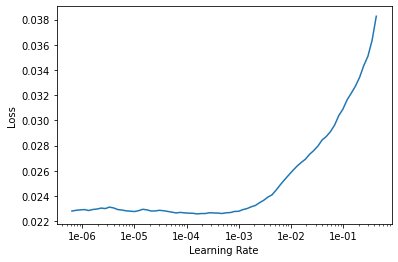

In [54]:
#Stage-1-rn50 plot
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(5, max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.022366,0.020188,0.993104,06:27
1,0.021599,0.018645,0.993475,06:29
2,0.019421,0.015771,0.994311,06:30
3,0.017084,0.014108,0.994904,06:29
4,0.015731,0.013764,0.995127,06:33


In [0]:
learn.save('stage-2-rn50-900')

In [0]:
learn.load('stage-2-rn50-900')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


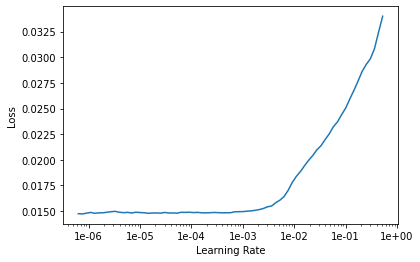

In [59]:
#Stage-2-rn50 plot
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(5, slice(1e-4, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.014976,0.013993,0.994655,08:12
1,0.015313,0.013704,0.994903,08:07
2,0.014360,0.011579,0.995694,08:08
3,0.012780,0.010106,0.996252,08:15
4,0.011626,0.009828,0.996329,08:12


In [0]:
learn.save('stage3-e4by10-900') #This model is overfitted. I use stage 2 for making prediction

In [0]:
learn.load('stage3-e4by10-900')

# Making a prediction using Danbooru


In [0]:
learn.export()

In [0]:
!mkdir danbooru

In [0]:
learn = load_learner(path)

In [35]:
len(data.classes)

4567

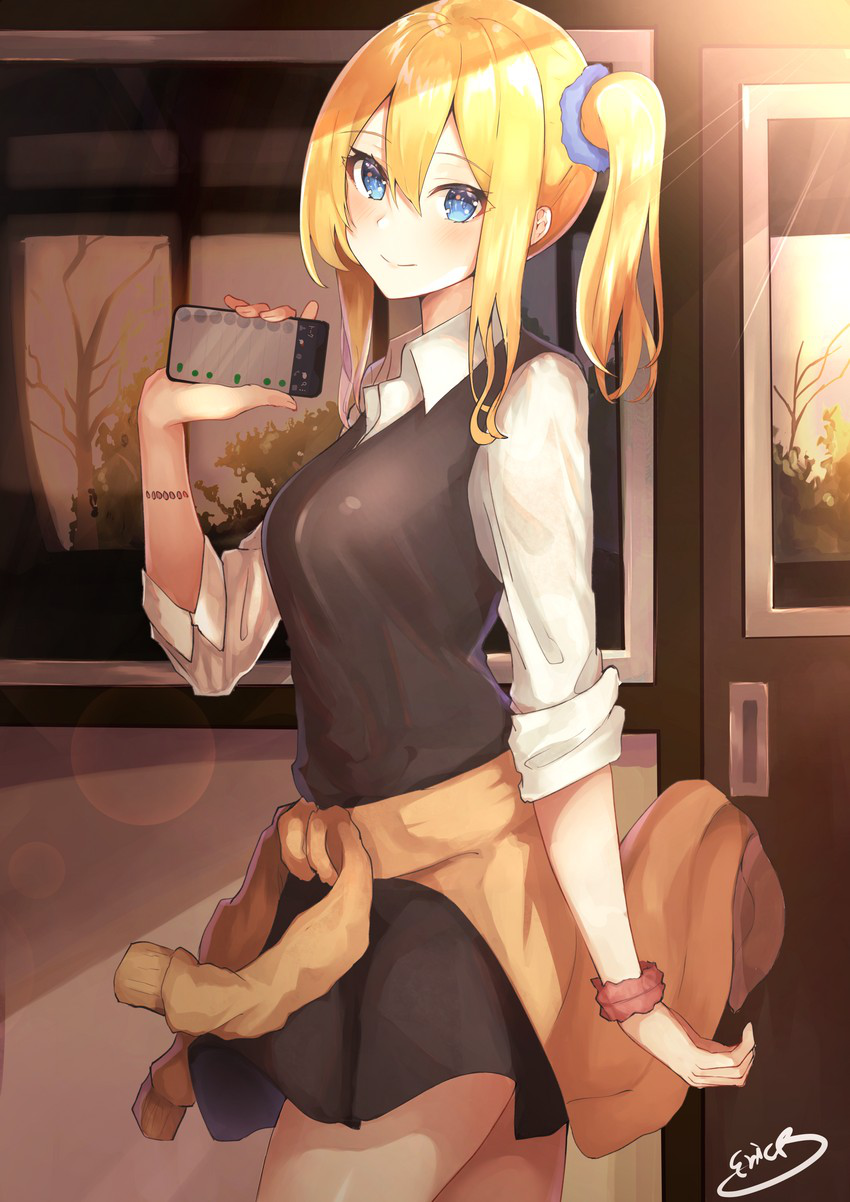

In [84]:
img = open_image('/content/danbooru/__hayasaka_ai_kaguya_sama_wa_kokurasetai_tensai_tachi_no_renai_zunousen_drawn_by_shiina_aoi__sample-802306a3cb35a9c2319564d615461478.jpg')
img

In [85]:
pred_class,pred_idx,outputs = learn.predict(img, thresh=0.3)
print(pred_class)

;1girl;bangs;breasts;brown_hair;highres;holding;indoors;long_hair;looking_at_viewer;original;shirt;sitting;solo;table;white_shirt;window


# Results with 300 images
Prediction using Danbooru image is showing a favorable result, with around 8/10 tag  is being correct applied to the image. However, it is to be noted that the predicted tag for the image is so little, that only generic tag and absolute tag is predicted (for example 1girl tag).  Few reasons for this come to mind, a) the amount of label is too small b) the datasets is small that the label cannot have high confidence.

Thus, the best way to handle this is to increase the datasets to increase the amount of label. For example, 1000 label should be best. The next step of experiment is too increase datasets to 900 and see what happens.


#Results with 900 images and 4000+ labels

Result of using 900 images from Safebooru is a just a bit better  despite quadrapling the amount of label. While it is an improvement over previous model, it still cannot accurately tag an image using niche tag. From manual estimation, it is guessed that prediction of tag increases ~20% compared to previous model.

However, incorrectly predicted tag is also increasing, for example, a girl wearing short uniform with gloves is predicted with tag "long_sleeves" despite the model correctly predicting "black_gloves". Also, predicting is flimsy, sometimes inputting 0.3 threshold give good result, other time it is incorrect. But for absolute prediction, just leave the threshold.

Some funny stuff, bun from character "akaza_akari" from anime yuru yuri is predicted to have hair ornament. xD

#Conclusion

All in all, I'm very satisfied with making this model. Although, it is not up to standard of user-tagged image, being able to make machine correctly predicting anime image is itself satisfying. Fun experiment on my road to learn fast.ai.

How do I improve this model? It is hard to specifically define what is needed to improve the model into user-tagged standard. Adding more label can helps, more datasets can help, obviously. But how much is enough? Aside from that, I do wonder how much impact does mistagged image can mess with the model (because the image from datasets is labelled by random people). If every image is scrunitized and cleaned, does the model be able to predict niche tags better? 

I also want to say that this can be done better (or maybe it's already done?). Better planning in determining datasets and removing bad data, as well as making sure the prioritizing tags will further improve this model. And sometimes removing niche tag can help as tag with only one or less than ten images can mess with the model accuracy. Overall, it can be done better.

A big challenge in this application is also to correctly predict character's name. It may required different approach because applying character images + character name to model is less efficient than creating a new model to predict character's name only. But who knows, maybe you can do better?